# Imports Modules

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

## Import Data Set


In [84]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/assesment')

## Reading Data

In [86]:
data = pd.read_csv('Data.csv', sep=';')
data.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3


## Data analysis

We check for null values to gain knowledge from the data set

In [87]:
data.isnull().sum(axis=0)

row_num                 0
locale                  0
day_of_week             0
hour_of_day             0
agent_id                0
entry_page              0
path_id_set          4889
traffic_type            0
session_durantion       0
hits                    0
dtype: int64

We find out that 'path_id_set' has null values. But we also noticed that 'session_durantion' and 'hits' contain '\N' values, this can cause a problem then we need to fix this.


In [0]:
# set proper datatypes
data['row_num'] = data['row_num'].astype(np.int)
data['locale'] = data['locale'].astype(str)
data['day_of_week'] = data['day_of_week'].astype(str)
data['hour_of_day'] = data['hour_of_day'].astype(np.int)
data['agent_id'] = data['agent_id'].astype(np.int)
data['entry_page'] = data['entry_page'].astype(np.int)
data.loc[data['path_id_set'].notnull(), 'path_id_set'] = data.loc[data['path_id_set'].notnull(), 'path_id_set'].astype(str)
data['traffic_type'] = data['traffic_type'].astype(str)

# 'session_durantion' and 'hits' contain '\N' values
# we will replace it with 0 for 'session_durantion' and NULL for 'hits'
data['session_durantion'] = pd.to_numeric(data['session_durantion'], errors='coerce')
data['session_durantion'] = data['session_durantion'].fillna(0)
data['hits'] = pd.to_numeric(data['hits'], errors='coerce')

## Values of the main features

We check each column to see how to treat them as categorical or continuous

### The platform of the session

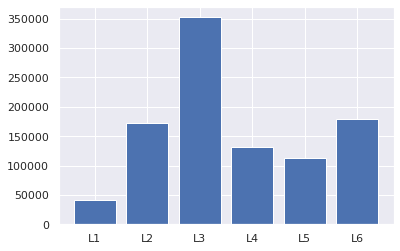

In [89]:
locales = data['locale'].value_counts().sort_index()

# show plot
plt.bar(locales.index, locales.values)
plt.show()

There are 6 platforms of the session and we will treat them as categorical variable.

### The day of the week of the session

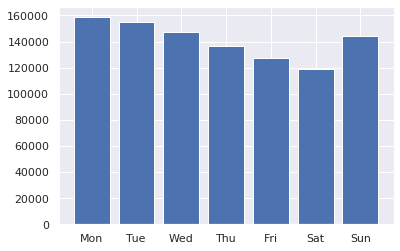

In [90]:
day_of_week = data['day_of_week'].value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# show plot
labels = [day[:3] for day in day_of_week.index] # display just first 3 characters of the day of the week
plt.bar(labels, day_of_week.values)
plt.show()

There are also 7 days of the week of the session. We will also treat it as a categorical variable.

### The hour of the day of the session

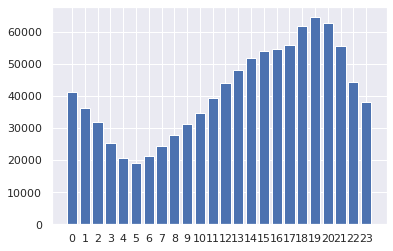

In [91]:
hour_of_day = data['hour_of_day'].value_counts().sort_index()
hour_of_day
# show plot
plt.bar(hour_of_day.index, hour_of_day.values)
plt.xticks(np.arange(24)) # set x ticks to be for each hour: np.arange(24) = [1,2,3,..,23]
plt.show()

There are 24 hours. They can be treated as categorical values or continuous values. Because there is a natural ordering of the values, we will treat this variable as continuous.





### The device used for the session

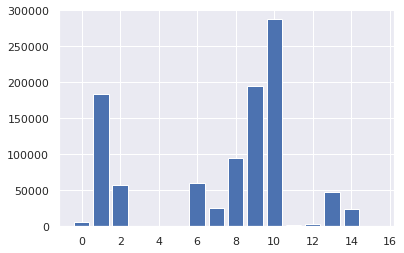

In [92]:
agent_id = data['agent_id'].value_counts().sort_index()

# show plot
plt.bar(agent_id.index, agent_id.values)
plt.show()

There are 16 devices used for the session. We will treat this variable as categorical.

In [93]:
agent_id = data['agent_id'].value_counts().sort_index()
agent_id

0       5359
1     184228
2      57077
3        121
4        222
       ...  
11      1986
12      3694
13     48169
14     24743
15       100
Name: agent_id, Length: 16, dtype: int64

### Entry page

There are 147 entry pages in total. We will keep the most frequent entry pages (min. 2000 records to keep the page).

In [94]:
pd.set_option('display.max_rows', 10)
data['entry_page'].value_counts()

2113    333163
2116    195904
2100    178912
2111     83687
2114     74050
         ...  
2848         1
2172         1
2892         1
2726         1
2380         1
Name: entry_page, Length: 147, dtype: int64

In [95]:
entry_page = data['entry_page'].value_counts().sort_index()
entry_page 

2100    178912
2111     83687
2113    333163
2114     74050
2115     16733
         ...  
8002        20
8006         4
8010        13
8020         8
8101       671
Name: entry_page, Length: 147, dtype: int64

In [96]:
entry_page = data['entry_page'].value_counts().sort_index()
print(entry_page[entry_page > 2000])

2100    178912
2111     83687
2113    333163
2114     74050
2115     16733
         ...  
2226      9840
2227      3024
2316      3332
2700     58330
8001     16309
Name: entry_page, Length: 11, dtype: int64


In [97]:
keep_entry_pages = entry_page[entry_page > 2000].index
data.loc[data['entry_page'].isin(keep_entry_pages) == False, 'entry_page'] = -1
data['entry_page'].value_counts().sort_index()

-1        15397
 2100    178912
 2111     83687
 2113    333163
 2114     74050
          ...  
 2226      9840
 2227      3024
 2316      3332
 2700     58330
 8001     16309
Name: entry_page, Length: 12, dtype: int64

There are 11 entry pages, which have more than 2000 records, so we will keep them and treat as categories. All the others will belong to category '-1'.

## Locations(path_id_set)

We also have the information about all the locations, which were visited during
the session. There would be too many categories, if we treated this data as categorical, which we cannot afford and train. But this data can still be useful for us. We can create a new variable, which can count the number of pages visited during the session and named 'n_pages_visited'.



In [0]:
data.loc[data['path_id_set'].notnull(), 'n_pages_visited'] = \
data.loc[data['path_id_set'].notnull(), 'path_id_set'].apply(lambda x: len(x.split(';')))

data.loc[data['path_id_set'].isnull() & (data['session_durantion'] > 0), 'n_pages_visited'] = 1
data.loc[data['path_id_set'].isnull() & (data['session_durantion'] == 0), 'n_pages_visited'] = 0

## traffic_type

There are 7 categories in traffic type. We treat this variable as categorical.



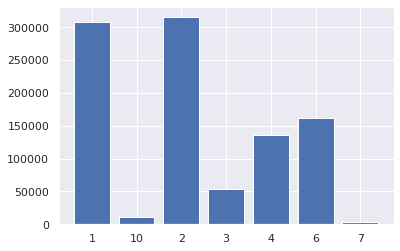

In [99]:
traffic_type = data['traffic_type'].value_counts().sort_index()

# show plot
plt.bar(traffic_type.index, traffic_type.values)
plt.show()

# Prepare data for training

#### We are going to perform several preprocessing steps:

1) Remove locations variable ('path_id_set'), because we do not need it anymore.<br>
2) Perform <b>one-hot-encoding</b> for categorical variables.<br>
3) There are a few extreme values of a target variable ('hits'), which we will replace by 342. Extreme values occur rarely, are difficult to predict and can cause problems while training, so we will focus on predicting casual occations (99.8%).



In [0]:
# remove 'path_id_set'
data = data.drop('path_id_set', axis=1)

# one-hot-encoding
data = pd.get_dummies(data, columns=['locale', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type'], drop_first=True)

In [101]:
hits_x=data[data['hits'].notnull()]['hits']
print("arr : ",hits_x)  
print("50th percentile of arr : ",  
       np.percentile(hits_x, 50)) 
print("25th percentile of arr : ", 
       np.percentile(hits_x, 25)) 
print("99.7th percentile of arr : ", 
       np.percentile(hits_x, 99.7)) 

arr :  1         14.0
2         14.0
3          1.0
4          3.0
5          2.0
          ... 
988671     3.0
988672    69.0
988674    37.0
988675     2.0
988680    18.0
Name: hits, Length: 619235, dtype: float64
50th percentile of arr :  7.0
25th percentile of arr :  3.0
99.7th percentile of arr :  284.0


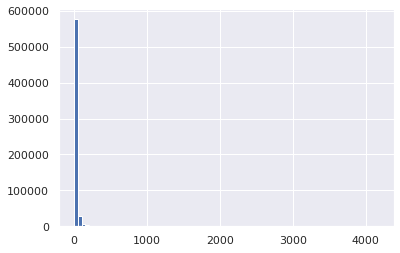

In [102]:
hits_x.hist(bins=80)
plt.show()

In [103]:
# to avoid bias we will replace extreme values
n_replaced = (data['hits'] > 284).sum()
print(f'{n_replaced}/{len(data)} will be replaced')

1856/988681 will be replaced


In [0]:
data.loc[data['hits'] > 284, 'hits'] = 284

In [0]:
train = data[data['hits'].notnull()]
pred = data[data['hits'].isnull()]

In [0]:
train_X = train.drop(['row_num', 'hits'], axis=1)
train_y = train['hits']

pred_X = pred.drop(['row_num', 'hits'], axis=1)
pred_row_num = pred['row_num']

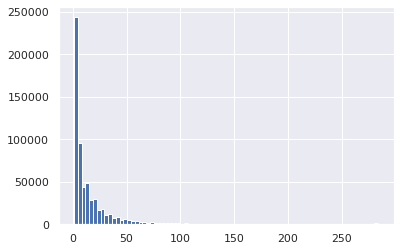

In [107]:
train_y.hist(bins=80)
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=7)

# Modelling

#### We are going to test 3 different models:
* Random Forest Regressor
* Linear Regression
* Multilayer Perceptron(MLP)


#### We split the data we have into several parts:

1) Data for prediction - data which have missing values in 'hits' column will be used for prediction<br>
2) Training-validating part:75%-of the randomly selected data, which have non-missing values in ‘hits’ columns, will be used for training using Cross-validation technique<br>
3) Testing part 25% of the randomly selected data, which have non-missing values in ‘hits’ columns, will be used for testing the models<br>
4) 5-Fold Cross Validation is also used to test and validate the model. <br>

#### Objective function

To find the best set of parameters and the best model we will use mean squared error.<br>


#### Error histogram
We will also evaluate our models visually using error histogram. Error histogram shows how much the predicted values deviate from the real values.

## Random Forest Regressor

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.7min
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed: 31.7min finished


Best params: {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 25}
Best score: -525.4141649426045
Test mse: 516.882159087373
 === ERROR HISTOGRAM ===


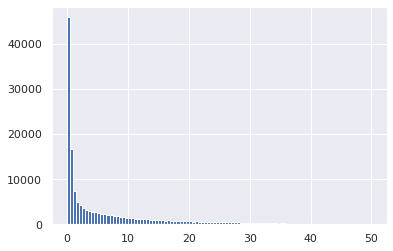

In [109]:
parameters = {'n_estimators':[15, 20, 25],
              'max_depth': [5, 10, 15],
              'max_features': [0.4, 0.5, 0.6]}

model_rf = GridSearchCV(RandomForestRegressor(), 
                        parameters, 
                        cv=5, 
                        verbose=True,
                        scoring='neg_mean_squared_error',
                        n_jobs=3)
model_rf.fit(X_train, y_train)

best_model_rf = model_rf.best_estimator_
preds_rf = best_model_rf.predict(X_test)
test_mse_rf = mean_squared_error(preds_rf, y_test)

print(f'Best params: {model_rf.best_params_}\n'
      f'Best score: {model_rf.best_score_}\n'
      f'Test mse: {test_mse_rf}')

print(' === ERROR HISTOGRAM ===')
difs_rf = abs(preds_rf - y_test)
plt.hist(difs_rf[difs_rf < 50], bins=100)
plt.show()

## Linear Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    9.1s finished


Best params: {}
Best score: -669.3964613392106
Test mse: 644.051127548636
 === ERROR HISTOGRAM ===


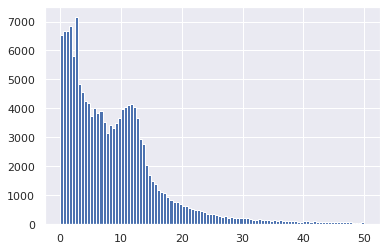

In [110]:
parameters = {}

model_lr = GridSearchCV(LinearRegression(), 
                        parameters, 
                        cv=5,
                        verbose=True, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=3)
model_lr.fit(X_train, y_train)

best_model_lr = model_lr.best_estimator_
preds_lr = best_model_lr.predict(X_test)
test_mse_lr = mean_squared_error(preds_lr, y_test)

print(f'Best params: {model_lr.best_params_}\n'
      f'Best score: {model_lr.best_score_}\n'
      f'Test mse: {test_mse_lr}')

print(' === ERROR HISTOGRAM ===')
difs_lr = abs(preds_lr - y_test)
plt.hist(difs_lr[difs_lr < 50], bins=100)
plt.show()

## MLP

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 33.3min finished


Best params: {'activation': 'relu', 'hidden_layer_sizes': (5, 10)}
Best score: -537.6848453230297
Test mse: 522.3476855943866
 === ERROR HISTOGRAM ===


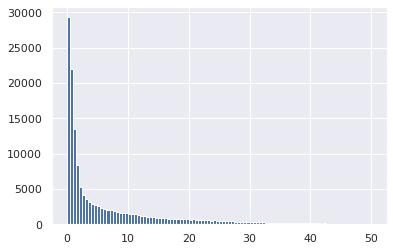

In [111]:
parameters = {'hidden_layer_sizes': [(5), (10), (5, 10), (10, 5), (10, 10)],
              'activation': ['relu']}

model_mlp = GridSearchCV(MLPRegressor(), 
                         parameters, 
                         cv=5, 
                         verbose=True, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)
model_mlp.fit(X_train, y_train)

best_model_mlp = model_mlp.best_estimator_
preds_mlp = best_model_mlp.predict(X_test)
test_mse_mlp = mean_squared_error(preds_mlp, y_test)

print(f'Best params: {model_mlp.best_params_}\n'
      f'Best score: {model_mlp.best_score_}\n'
      f'Test mse: {test_mse_mlp}')

print(' === ERROR HISTOGRAM ===')
difs_mlp = abs(preds_mlp - y_test)
plt.hist(difs_mlp[difs_mlp < 50], bins=100)
plt.show()

# Results

The performance on the test set among the 3 trained models is the following:<br>
* Random Forest Regressor: mse=516,88
* Linear Regression: mse=644,05
* MLP: mse=522,34

Random Forest Regressor has shown the best performance during cross validation and testing, so we will choose it as our final model for predictions.

# Prediction

In [115]:
predictions = best_model_rf.predict(pred_X).astype(np.int)
predictions

array([36, 63,  3, ..., 13,  9, 16])

In [0]:
predictions = best_model_rf.predict(pred_X).astype(np.int)
predictions_df = pd.DataFrame({'id': pred_row_num, 'hits_prediction': predictions})
predictions_df.to_csv('predictions.csv', index=False, sep=';')